<a href="https://colab.research.google.com/github/jiruneko/colab_object_detection/blob/main/expert_object_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
print('Hello World')

x = torch.tensor([1, 2, 3, 4])
print('CPU', x)

x = x.to('cuda')
print('GPU', x)

Hello World
CPU tensor([1, 2, 3, 4])
GPU tensor([1, 2, 3, 4], device='cuda:0')


In [ ]:
from PIL import Image

import numpy as np

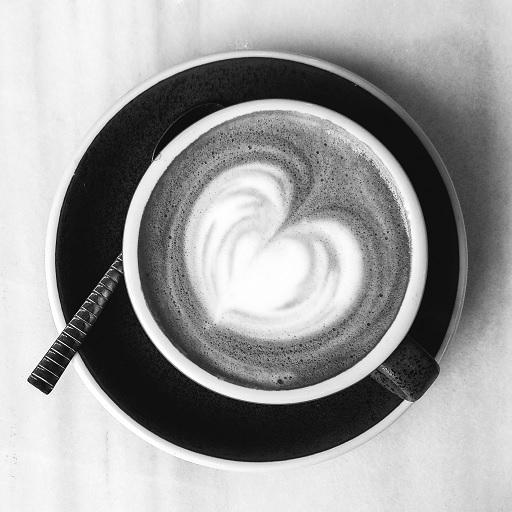

In [ ]:
img_gray = Image.open('/content/coffee.jpg')
display(img_gray)

In [ ]:
print('グレースケール画像を保持する配列の形: {}'. format(np.array(img_gray).shape))
print('グレースケール画像の(0, 0)における画素数: {}'. format(img_gray.getpixel((0, 0))))

グレースケール画像を保持する配列の形: (512, 512)
グレースケール画像の(0, 0)における画素数: 240


In [ ]:
def generate_gaussian_kernel(
    kernel_width: int,
    kernel_height: int,
    sigma: float):
  assert kernel_width % 2 == 1 and kernel_height % 2 == 1

  # カーネル用の変数を用意
  kernel = np.empty((kernel_height, kernel_width))

  for y in range(-(kernel_height // 2), kernel_height // 2 + 1):
    for x in range(-(kernel_width // 2), kernel_width // 2 + 1):
      # ガウス分泌から値を抽出しカーネルに代入
      h = -(x ** 2 + y ** 2) / (2 * sigma ** 2)
      kernel[y + kernel_height // 2, x + kernel_width // 2] = np.exp(h)

  # 正規化
  kernel /= np.sum(kernel)

  return kernel

In [ ]:
def convolution(img: Image.Image, kernel: np.ndarray, x: int, y: int):
  width, height = img.size
  kernel_height, kernel_width = kernel.shape[:2]
  # 畳み込み演算
  value = 0
  for y_kernel in range(-(kernel_height // 2),
                        kernel_height // 2 + 1):
    for x_kernel in range(-(kernel_width // 2),
                          kernel_width // 2 + 1):
      x_img = max(min(x + x_kernel, width - 1), 0)
      y_img = max(min(y + y_kernel, height - 1), 0)
      h = kernel[y_kernel + kernel_height // 2, x_kernel + kernel_width // 2]
      value += h * img.getpixel((x_img, y_img))

  return value

In [ ]:
def apply_filter(img: Image.Image, kernel: np.ndarray):
  # 画像サイズとカーネルサイズの取得
  width, height = img.size

  # フィルタ適用後の画像を保持する変数を用意
  img_filtered = Image.new(mode='L', size=(width, height))

  # フィルタ適用後の各画素値の計算
  img_filtered = Image.new(mode='L', size=(width, height))

  # フィルタ適用後の各画素値の計算
  for y in range(height):
    for x in range(width):
      filtered_value = convolution(img, kernel, x, y)
      img_filtered.putpixel((x, y), int(filtered_value))

  return img_filtered

In [ ]:
# ガウシアンカーネルの生成
kernel = generate_gaussian_kernel(
    kernel_width=5, kernel_height=5, sigma=1.3)

# カーネルの表示
print('ガウシアンカーネル:')
print(kernel)

ガウシアンカーネル:
[[0.0097565  0.02370077 0.03186045 0.02370077 0.0097565 ]
 [0.02370077 0.0575746  0.07739634 0.0575746  0.02370077]
 [0.03186045 0.07739634 0.10404229 0.07739634 0.03186045]
 [0.02370077 0.0575746  0.07739634 0.0575746  0.02370077]
 [0.0097565  0.02370077 0.03186045 0.02370077 0.0097565 ]]


元のノイズ画像


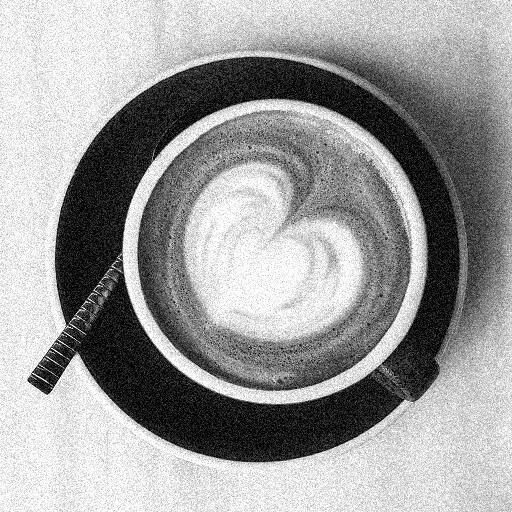

フィルタ適用後の画像


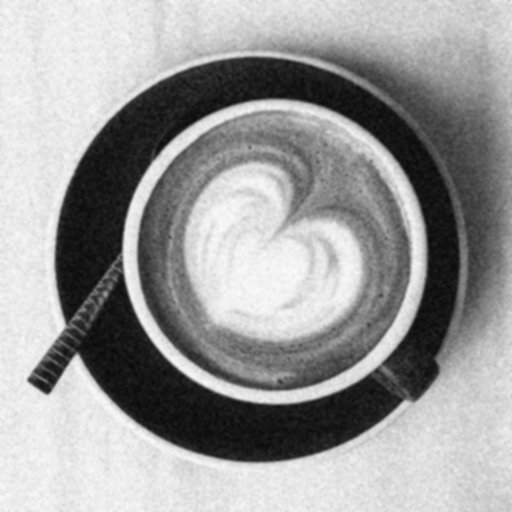

In [ ]:
# 画像の読み込み
img = Image.open('/content/coffee_noise.jpg')

# ガウシアンフィルタの適用
img_filtered = apply_filter(img, kernel)

# 元画像とフィルタ適用後の画像の表示
print('元のノイズ画像')
display(img)
print('フィルタ適用後の画像')
display(img_filtered)

In [ ]:
from scipy import signal

In [ ]:
def generate_kernel():
  kernel_h = np.zeros((3, 3))
  kernel_v = np.zeros((3, 3))
  kernel_lap = np.zeros((3, 3))

  # 水平方向の1時微分のカーネルの値を設定
  kernel_h[1, 1] = -1
  kernel_h[1, 2] = 1
  # 垂直方向の1次微分のカーネルの値を設定
  kernel_v[1, 1] = -1
  kernel_v[2, 1] = 1
  # ラプラシアンフィルタのカーネルの値を設定
  kernel_lap[0, 1] = 1
  kernel_lap[1, 0] = 1
  kernel_lap[1, 2] = 1
  kernel_lap[2, 1] = 1
  kernel_lap[1, 1] = -4

  return kernel_h, kernel_v, kernel_lap

In [ ]:
kernel_h, kernel_v, kernel_lap = generate_kernel()
print('水平方向の1次微分カーネル')
print(kernel_h)
print('垂直方向の1次微分カーネル')
print(kernel_v)
print('ラプラシアンフィルタのカーネル')
print(kernel_lap)

水平方向の1次微分カーネル
[[ 0.  0.  0.]
 [ 0. -1.  1.]
 [ 0.  0.  0.]]
垂直方向の1次微分カーネル
[[ 0.  0.  0.]
 [ 0. -1.  0.]
 [ 0.  1.  0.]]
ラプラシアンフィルタのカーネル
[[ 0.  1.  0.]
 [ 1. -4.  1.]
 [ 0.  1.  0.]]


In [ ]:
img = Image.open('/content/coffee.jpg')

# NumpyとSciPyを使うため画像をNumPy配列に変換
img = np.asarray(img, dtype='int32')

img_h_diff = signal.convolve2d(
    img, kernel_h, mode='same', boundary='symm')
img_v_diff = signal.convolve2d(
    img, kernel_v, mode='same', boundary='symm')
img_lap = signal.convolve2d(
    img, kernel_lap, mode='same', boundary='symm')

# 微分値の絶対値を計算
img_h_diff = np.absolute(img_h_diff)
img_v_diff = np.absolute(img_v_diff)

# 水平1次微分画像と垂直1次微分画像の合成
img_diff = (img_h_diff ** 2 + img_v_diff ** 2) ** 0.5

In [ ]:
# 範囲を超えた画素値をクリップ
img_h_diff = np.clip(img_h_diff, 0, 255).astype('uint8')
img_v_diff = np.clip(img_v_diff, 0, 255).astype('uint8')
img_diff = np.clip(img_diff, 0, 255).astype('uint8')
img_lap = np.clip(img_lap, 0, 255).astype('uint8')

水平方向の1次微分フィルタを適用した画像


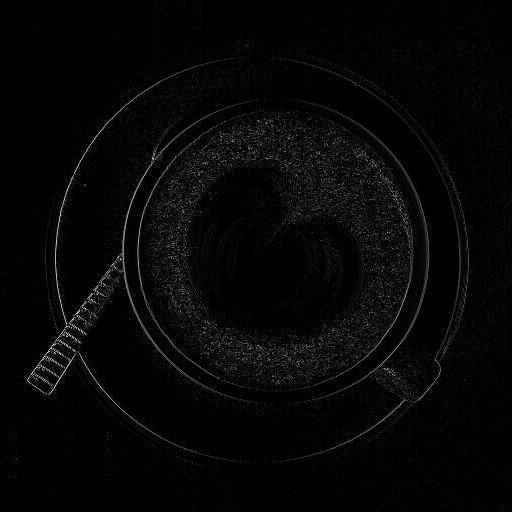

垂直方向の1次微分フィルタを適用した画像


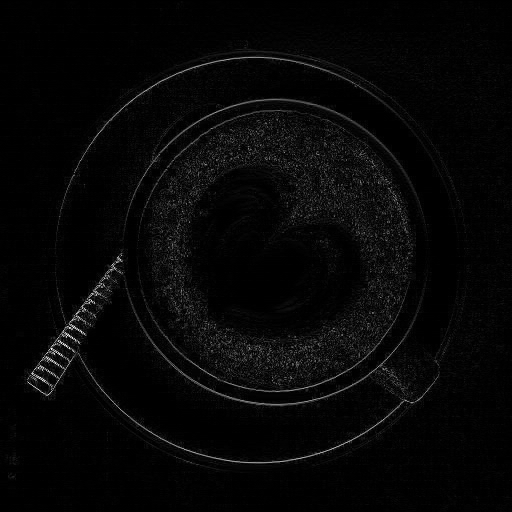

水平1次微分と垂直1次微分を合成した画像


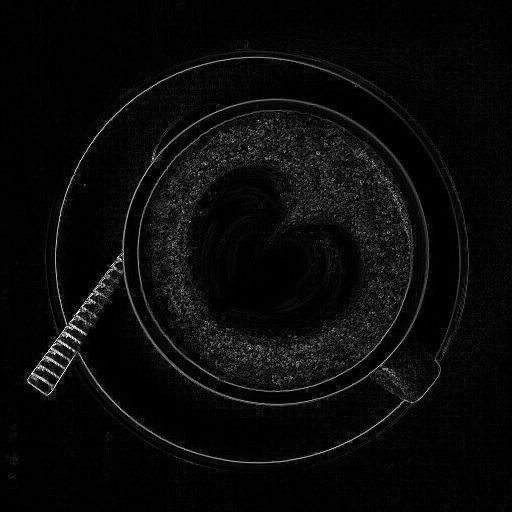

ラプラシアンフィルタを適用した画像


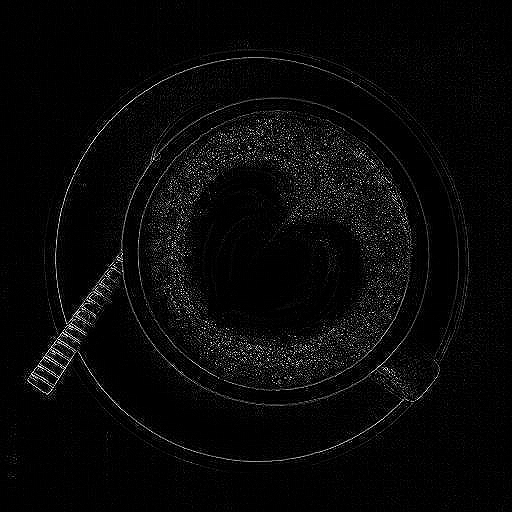

In [ ]:
img_h_diff = Image.fromarray(img_h_diff)
img_v_diff = Image.fromarray(img_v_diff)
img_diff = Image.fromarray(img_diff)
img_lap = Image.fromarray(img_lap)

print('水平方向の1次微分フィルタを適用した画像')

display(img_h_diff)
print('垂直方向の1次微分フィルタを適用した画像')
display(img_v_diff)
print('水平1次微分と垂直1次微分を合成した画像')
display(img_diff)
print('ラプラシアンフィルタを適用した画像')
display(img_lap)

In [ ]:
img = Image.open('/content/cosmos.jpg')

# NumPyを使うため画像をNumPy配列に変換
img = np.asarray(img, dtype='float32')

# 画像を特徴空間に射影
w = np.array([[0.0065, -0.0045, -0.0018, 0.0075,
               0.0095, 0.0075, -0.0026, 0.0022,],
              [-0.0065, 0.0081, 0.0097, -0.0070,
               -0.0086, -0.0107, 0.0062, -0.0050],
              [0.0024, -0.0018, 0.0002, 0.0023,
               0.0017, 0.0021, -0.0017, 0.0016]])
features = np.matmul(img, w)

In [ ]:
# アテンション計算用の特徴を画像から抽出
feature_white = features[50, 50]
feature_pink = features[200, 200]

# アテンションの計算
atten_white = np.matmul(features, feature_white)
atten_pink = np.matmul(features, feature_pink)

# アテンションの正規化・ソフトマックスの計算
atten_white = np.exp(atten_white) / np.sum(np.exp(atten_white))
atten_pink = np.exp(atten_pink) / np.sum(np.exp(atten_pink))

白のコスモスに対するアテンション


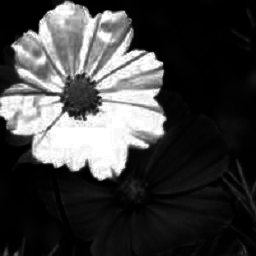

ピンクのコスモスに対するアテンション


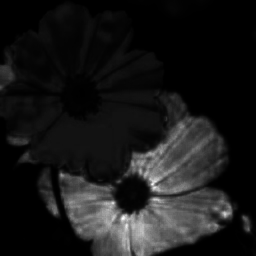

In [ ]:
# 表示ように最大・最小で正規化
atten_white = (atten_white - np.amin(atten_white)) / (np.amax(atten_white) - np.amin(atten_white))
atten_pink = (atten_pink - np.amin(atten_pink)) / (np.amax(atten_pink) - np.amin(atten_pink))

# NumPy配列をPIL画像に変換
img_atten_white = Image.fromarray(
    (atten_white * 255).astype('uint8'))
img_atten_pink = Image.fromarray(
    (atten_pink * 255).astype('uint8'))
print('白のコスモスに対するアテンション')
display(img_atten_white)
print('ピンクのコスモスに対するアテンション')
display(img_atten_pink)